# Assignment 2: Text Classification with Deep Averaged Networks

**Description:** This assignment covers various neural network architectures and components, largely used in the context of classification. You will compare Deep Averaging Networks, Deep Weighted Averaging Networks using Attention, and BERT-based models. In part one, you should be able to develop an intuition for:


*   The effects of fine-tuning word vectors or starting with random word vectors
*   How various networks behave when the training set size changes
*   The effect of shuffling your training data
*   The effect of fine tuning your embeddings



The assignment notebook closely follows the lesson notebooks. We will use the IMDB dataset and will leverage some of the models, or part of the code, for our current investigation.

This notebook uses the Keras 3 functional API.  Make sure the correct versions get loaded.







## IMPORTANT NOTE:
Because of the environment built in to Colab, the software we're importing causes an error to be thrown the first time you run the cells in the Setup section.  As soon as you hit the error, you have to go to the Runtime menu and select 'Restart Session'.  Once the session is restarted you must rerun the cells in Setup and you will not run in to the error.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2025-summer-main/blob/master/assignment/a2/Text_classification_DAN.ipynb)

The overall assignment structure is as follows:


0. Setup
  
  0.1 Libraries, Embeddings,  & Helper Functions

  0.2 Data Acquisition

  0.3. Data Preparation

    0.3.1 Training/Test Sets using Word2Vec

    0.3.2 Training/Test Sets for BERT-based models


1. Classification with various Word2Vec-based Models

  1.1 The Role of Shuffling of the Training Set

  1.2 DAN
    
  1.3 Approaches for Training of Embeddings



**INSTRUCTIONS:**:

* Questions are always indicated as **QUESTION**, so you can search for this string to make sure you answered all of the questions. You are expected to fill out, run, and submit this notebook, as well as to answer the questions in the **answers** file as you did in a1.  Please do **not** remove the output from your notebooks when you submit them as we'll look at the output as well as your code for grading purposes.  We cannot award points if the output cells are empty.

* **### YOUR CODE HERE** indicates that you are supposed to write code.

* If you want to, you can run all of the cells in section 0 in bulk. This is setup work and no questions are in there. At the end of section 0 we will state all of the relevant variables that were defined and created in section 1.

* Finally, unless otherwise indicated your validation accuracy will be 0.65 or higher if you have correctly implemented the model.

## 0. Setup

### 0.1. Libraries and Helper Functions

This notebook requires the TensorFlow dataset and other prerequisites that you must download.  THis model uses the Keras 3 interface.

In [ ]:
#@title Installs
!pip install numpy==1.26.4 --quiet
!pip install scipy==1.13.0 --quiet
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow-datasets --quiet
!pip install tensorflow-text --quiet


Now we are ready to do the imports.

In [ ]:
#@title Imports
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

from keras.layers import Embedding, Input, Dense, Lambda
from keras.models import Model

import tensorflow_datasets as tfds
import tensorflow_text as tf_text


import sklearn as sk

import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [ ]:
def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")


In [ ]:
#confirm versions
print_version('numpy')
print_version('tensorflow')
print_version('keras')

numpy version: 1.26.4
tensorflow version: 2.18.0
keras version: 3.8.0


Make sure you are using a Keras version > 3.0 and a tensorflow version > 2.16.0 for this notebook.

Below is a helper function to plot histories.

In [ ]:
#@title Plotting Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

Next, we get the word2vec model from NLTK to use as our embeddings.

In [ ]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

wvmodel = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


Now here we have the embedding **model** defined, let's see how many words are in the vocabulary:

In [ ]:
len(wvmodel)

43981

What do the word vectors look like? As expected:

In [ ]:
wvmodel['great'][:20]

array([ 0.0306035 ,  0.0886877 , -0.0121269 ,  0.0761965 ,  0.0566269 ,
       -0.0424702 ,  0.0410129 , -0.0497567 , -0.00364328,  0.0632889 ,
       -0.0142608 , -0.0791111 ,  0.0174877 , -0.0383064 ,  0.00926433,
        0.0295626 ,  0.0770293 ,  0.0949334 , -0.0428866 , -0.0295626 ],
      dtype=float32)

We can now build the embedding matrix and a vocabulary dictionary:

In [ ]:
EMBEDDING_DIM = len(wvmodel['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(wvmodel) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(wvmodel.index_to_key):
    embedding_vector = wvmodel[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [ ]:
embedding_matrix.shape

(43982, 300)

In [ ]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

The last row consists of all zeros. We will use that for the UNK token, the placeholder token for unknown words.

### 0.2 Data Acquisition


We will use the IMDB dataset delivered as part of the TensorFlow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [ ]:
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CD8B3R_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CD8B3R_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CD8B3R_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


It is always highly recommended to look at the data. What do the records look like? Are they clean or do they contain a lot of cruft (potential noise)?

In [ ]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [ ]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

For convenience, in this assignment we will define a sequence length and truncate all records at that length. For records that are shorter than our defined sequence length we will add padding characters to insure that our input shapes are consistent across all records.

In [ ]:
MAX_SEQUENCE_LENGTH = 100

## 0.3. Data Preparation

### 0.3.1. Training/Test Sets for Word2Vec-based Models

First, we tokenize the data:

In [ ]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Let's look at some tokens.  Do they look acceptable?

In [ ]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

Next, we define a simple function that converts the tokens above into the appropriate word2vec index values so we can retrieve the embedding vector associated with the word.   

In [ ]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    text_labels = []
    valid_example_list = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with unknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding
        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)
    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.  We need to convert all of the tokens in to their respective input ids.

In [ ]:
train_input_ids = docs_to_vocab_ids(train_tokens)
test_input_ids = docs_to_vocab_ids(test_tokens)

train_input_labels = np.array(train_labels)
test_input_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Total examples:  19999
Examples processed:  0
Total examples:  4999


Let's convince ourselves that the data looks correct:

In [ ]:
train_input_ids[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958],
       [12139,  7841, 19666, 31757, 43981, 17853, 25745, 15445, 43981,
        19123, 35029, 16908, 21113, 21068, 43981, 43981,  5668, 43981,
        33456, 43981, 34554, 43981,  1200, 27498, 43981, 1880

Overall, here are the key variables and sets that we encoded for word2vec and BERT and that may be used moving forward. If the variable naming does not make it obvious, we also state the purpose:

#### Parameters:

* MAX_SEQUENCE_LENGTH (100)


#### Word2vec-based models:

* train(/test)_input_ids: input ids for the training(/test) sets for word2vec models
* train(/test)_input_labels: the corresponding labels


**NOTE:** We recommend you inspect these variables if you have not gone through the code.

### 1  Keras Functional API warm up

Shown below is the output of a call to model summary.  It shows a network with specific named layers.  You are to reproduce the model that generated this summary.

**QUESTION:**

1.a Create a model using the Keras functional API so that the model.summary() call of your model identically reproduces the model summary shown here:

**Model Summary Output To Reproduce**
```
Model: "a2_question1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
_________________________________________________________________
 input_words (InputLayer)    [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          13194600  
                                                                 
 lambda (Lambda)             (None, 300)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               90300     
                                                                 
 hidden2 (Dense)             (None, 200)               60200     
                                                                 
 output (Dense)              (None, 5)                 1005      
                                                                 
__________________________________________________________________
Total params: 13346105 (50.91 MB)
Trainable params: 151505 (591.82 KB)
Non-trainable params: 13194600 (50.33 MB)
_________________________________________________________________
```

In [ ]:
input_x = Input(shape = (MAX_SEQUENCE_LENGTH,), name="input_words")

### YOUR CODE HERE

# Embedding layer - frozen (non-trainable)
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],     # vocab size
    output_dim=embedding_matrix.shape[1],    # embedding dimension
    weights=[embedding_matrix],
    trainable=False,
    name="embedding"
)(input_x)

# Lambda layer - average over time dimension (sequence axis)
averaged = Lambda(lambda x: tf.reduce_mean(x, axis=1), name="lambda")(embedding_layer)

# Dense layers
dense1 = Dense(300, activation='relu', name="hidden1")(averaged)
dense2 = Dense(200, activation='relu', name="hidden2")(dense1)

# Output layer for 5-class classification
output = Dense(5, activation='softmax', name="output")(dense2)

# Build the model
model = Model(inputs=input_x, outputs=output, name="a2_question1")

### END YOUR CODE

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
#Run this cell to generate your summary to match the summary output dabove
model.summary()

Model: "a2_question1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_words (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 300)       │    13,194,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │         1,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,346,105 (50.91 MB)

 Trainable params: 151,505 (591.82 KB)

 Non-trainable params: 13,194,600 (50.33 MB)

## 1.1 Classification with various Word2Vec-based Models

**QUESTION:**

1.1.a. Revisit the dataset. Is it balanced? Find the percentage of positive examples in the training set. (Copy and paste the decimal value for your calculation, e.g. a number like 0.5678 or 0.8765)

In [ ]:
### YOUR CODE HERE
positive_percentage = np.mean(train_input_labels)
print(f"Percentage of positive examples: {positive_percentage:.4f}")
### END YOUR CODE

Percentage of positive examples: 0.4985


**QUESTION:**

1.1.b. Now find the percentage of positive examples in the test set.  (Copy and paste the decimal value for your calculation, e.g. a number like 0.5678 or 0.8765)

In [ ]:
### YOUR CODE HERE
positive_percentage_test = np.mean(test_input_labels)
print(f"Percentage of positive examples in test set: {positive_percentage_test:.4f}")
### END YOUR CODE

Percentage of positive examples in test set: 0.5026


### 1.2 The Role of Shuffling of the Training Set


We will first revisit the DAN model.

Reuse the code from the class notebook to build a DAN network with one hidden layer of dimension 100. The optimizer should be Adam. Wrap the model creation in a function according to this API:

In [ ]:
def create_dan_model(retrain_embeddings=False,
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec',
                     learning_rate=0.001):
  """
  Construct the DAN model including the compilation and return it. Parametrize it using the arguments.
  :param retrain_embeddings: boolean, indicating whether  the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """

  if embedding_initializer == 'word2vec':
    embeddings_initializer=keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'


  ### YOUR CODE HERE

  # start by creating the dan_embedding_layer. Use the embeddings_initializer. variable defined above.

  # Input layer
  input_x = Input(shape=(max_sequence_length,), name="input_words")

  # Embedding layer
  dan_embedding_layer = Embedding(
      input_dim=embedding_matrix.shape[0],
      output_dim=embedding_matrix.shape[1],
      embeddings_initializer=embeddings_initializer,
      trainable=retrain_embeddings,
      name="embedding"
  )(input_x)

  # Averaging over sequence length
  averaged = Lambda(lambda x: tf.reduce_mean(x, axis=1), name="average")(dan_embedding_layer)

  # Hidden dense layer with dropout
  hidden = Dense(hidden_dim, activation='relu', name="hidden")(averaged)
  dropout_layer = tf.keras.layers.Dropout(dropout, name="dropout")(hidden)

  # Output layer (binary classification)
  output = Dense(2, activation='softmax', name="output")(dropout_layer)

  # Build model
  dan_model = Model(inputs=input_x, outputs=output, name="dan_model")

  # Compile model
  dan_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

  ### END YOUR CODE
  return dan_model


Let us create a sorted version of the training dataset to run some simulations and see what happens if we feed the model sorted data.  What do you think will happen if we train on sorted data?

In [ ]:
sorted_train_input_data = [(x, y) for (x, y) in zip(list(train_input_ids), list(train_input_labels))]
sorted_train_input_data.sort(key = lambda x: x[1])
sorted_training_input_ids = np.array([x[0] for x in sorted_train_input_data])
sorted_training_labels = np.array([x[1] for x in sorted_train_input_data])

Next, create your DAN model using the default parameters and train it by:

1.  Using the sorted dataset
2.  Using 'shuffle=False' as one of the model.fit parameters.
3.  Train for 10 epochs with a batch size of 32

Make sure you store the history (name it 'dan_sorted_history') as we did in the lesson notebooks.



In [ ]:
### YOUR CODE HERE

dan_model_sorted = create_dan_model()

#use dan_sorted_history = ... below

# Train on sorted data without shuffling
dan_sorted_history = dan_model_sorted.fit(
    sorted_training_input_ids,
    sorted_training_labels,
    validation_data=(test_input_ids, test_input_labels),
    batch_size=32,
    epochs=10,
    shuffle=False
)

### END YOUR CODE

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9230 - loss: 0.3203 - val_accuracy: 0.5026 - val_loss: 1.3319
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.1982 - loss: 1.2075 - val_accuracy: 0.5026 - val_loss: 0.8807
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2998 - loss: 0.8166 - val_accuracy: 0.5026 - val_loss: 2.7112
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5003 - loss: 1.5017 - val_accuracy: 0.5026 - val_loss: 1.2462
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5182 - loss: 0.9405 - val_accuracy: 0.5026 - val_loss: 1.0696
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5151 - loss: 0.8742 - val_accuracy: 0.5026 - val_loss: 1.9666
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5220 - loss: 1.1603 - val_accuracy: 0.5026 - val_loss: 1.2792
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5572 - loss: 0.8920 - val_accuracy: 0.

**QUESTION:**

1.2.a What is the final validation accuracy that you observed after you completed the 10 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)

Hint: You should have an accuracy number above 0.30.



Next, recreate the same model and train it with **'shuffle=True'**. (Note that this is also the default.). Use 'dan_shuffled_history' for the history.

In [ ]:
### YOUR CODE HERE

dan_model_shuffled = create_dan_model()

#use dan_shuffled_history = ... below

# Train on original data with shuffling (default behavior)
dan_shuffled_history = dan_model_shuffled.fit(
    train_input_ids,
    train_input_labels,
    validation_data=(test_input_ids, test_input_labels),
    batch_size=32,
    epochs=10,
    shuffle=True
)

### END YOUR CODE

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6019 - loss: 0.6646 - val_accuracy: 0.7184 - val_loss: 0.5741
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7284 - loss: 0.5501 - val_accuracy: 0.7268 - val_loss: 0.5427
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7486 - loss: 0.5162 - val_accuracy: 0.7440 - val_loss: 0.5196
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7521 - loss: 0.5123 - val_accuracy: 0.7534 - val_loss: 0.5097
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7616 - loss: 0.4941 - val_accuracy: 0.7458 - val_loss: 0.5122
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7579 - loss: 0.4952 - val_accuracy: 0.7524 - val_loss: 0.5033
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7634 - loss: 0.4851 - val_accuracy: 0.7506 - val_loss: 0.5065
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7723 - loss: 0.4823 - val_accuracy: 0.

**QUESTION:**

1.2.b What is the final validation accuracy that you observed for the shuffled run after completing 10 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)


Compare the 2 histories in a plot.

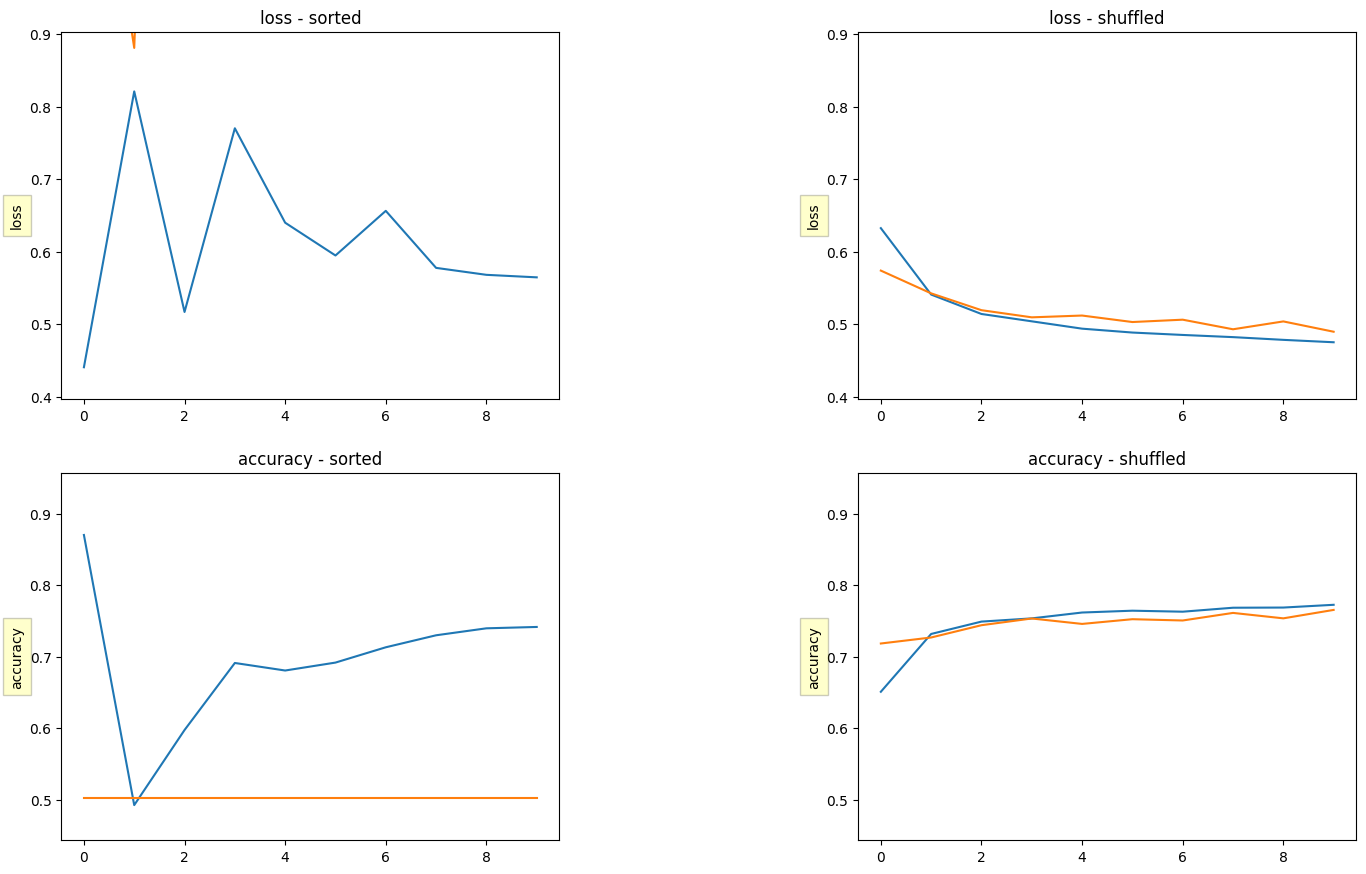

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_sorted_history,
          dan_shuffled_history,
          model_1_name='sorted',
         model_2_name='shuffled')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

### 1.3 Approaches for Training of Embeddings

Rerun the DAN Model in 3 separate configurations:


a.   embedding_initializer = 'word2vec' and retrain_embeddings=False

b.   embedding_initializer = 'word2vec' and retrain_embeddings=True

c.   embedding_initializer = 'uniform' and retrain_embeddings=True


**NOTE:** Train the model with static embeddings for 10 epochs and the ones with trainable embeddings for 3 epochs each. Make sure you are using the original training data we created and not the sorted data.

What do you observe about the effects of initializing and retraining the embedding matrix?



**QUESTION:**

1.3.a First, what is the final validation accuracy that you just observed for the static model initialized with the word2vec after 10 epochs?  (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)

In [ ]:
#1.3.a
### YOUR CODE HERE

dan_static_w2v_model = create_dan_model(
    retrain_embeddings=False,
    embedding_initializer='word2vec'
)

dan_static_w2v_history = dan_static_w2v_model.fit(
    train_input_ids,
    train_input_labels,
    validation_data=(test_input_ids, test_input_labels),
    batch_size=32,
    epochs=10,
    shuffle=True
)

# Print final validation accuracy
final_val_acc_static = dan_static_w2v_history.history['val_accuracy'][-1]
print(f"Final validation accuracy (static w2v): {final_val_acc_static:.4f}")

### END YOUR CODE

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6006 - loss: 0.6640 - val_accuracy: 0.6892 - val_loss: 0.5885
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7284 - loss: 0.5509 - val_accuracy: 0.7394 - val_loss: 0.5310
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7453 - loss: 0.5199 - val_accuracy: 0.7450 - val_loss: 0.5179
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7495 - loss: 0.5109 - val_accuracy: 0.7380 - val_loss: 0.5212
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7585 - loss: 0.4989 - val_accuracy: 0.7540 - val_loss: 0.5047
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7613 - loss: 0.4942 - val_accuracy: 0.7538 - val_loss: 0.5007
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7643 - loss: 0.4826 - val_accuracy: 0.7608 - val_loss: 0.4961
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7698 - loss: 0.4796 - val_accuracy

**QUESTION:**


1.3.b What is the final validation accuracy that you observed for the model where you initialized with word2vec vectors but allow them to retrain for 3 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)



In [ ]:
#1.3.b
### YOUR CODE HERE

dan_finetuned_w2v_model = create_dan_model(
    retrain_embeddings=True,
    embedding_initializer='word2vec'
)

dan_finetuned_w2v_history = dan_finetuned_w2v_model.fit(
    train_input_ids,
    train_input_labels,
    validation_data=(test_input_ids, test_input_labels),
    batch_size=32,
    epochs=3,
    shuffle=True
)

# Print final validation accuracy
final_val_acc_finetuned = dan_finetuned_w2v_history.history['val_accuracy'][-1]
print(f"Final validation accuracy (finetuned w2v): {final_val_acc_finetuned:.4f}")


### END YOUR CODE

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 221ms/step - accuracy: 0.6679 - loss: 0.5932 - val_accuracy: 0.7928 - val_loss: 0.4394
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 134s 209ms/step - accuracy: 0.8525 - loss: 0.3455 - val_accuracy: 0.7832 - val_loss: 0.4809
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 205ms/step - accuracy: 0.8946 - loss: 0.2654 - val_accuracy: 0.7842 - val_loss: 0.4812
Final validation accuracy (finetuned w2v): 0.7842


**QUESTION:**

1.3.c What is the final validation accuracy that you observed for the model where you initialized randomly and then trained?  (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)




In [ ]:
#1.3.c
### YOUR CODE HERE

dan_random_init_model = create_dan_model(
    retrain_embeddings=True,
    embedding_initializer='uniform'
)

dan_random_init_history = dan_random_init_model.fit(
    train_input_ids,
    train_input_labels,
    validation_data=(test_input_ids, test_input_labels),
    batch_size=32,
    epochs=3,
    shuffle=True
)

# Print final validation accuracy
final_val_acc_random = dan_random_init_history.history['val_accuracy'][-1]
print(f"Final validation accuracy (random init, trained): {final_val_acc_random:.4f}")


### END YOUR CODE

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 210ms/step - accuracy: 0.6598 - loss: 0.6008 - val_accuracy: 0.7954 - val_loss: 0.4409
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 129s 206ms/step - accuracy: 0.8534 - loss: 0.3463 - val_accuracy: 0.7878 - val_loss: 0.4489
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 199ms/step - accuracy: 0.8965 - loss: 0.2631 - val_accuracy: 0.7562 - val_loss: 0.5411
Final validation accuracy (random init, trained): 0.7562
